# Sentimental Analysis
[감성분석](https://dbr.donga.com/article/view/1202/article_no/8891/ac/magazine)

## 텍스트 데이터 분석 - 숫자로 표현

In [1]:
# 처리해야 할 문장을 파이썬 리스트에 옮겨담았습니다.
sentences=['i feel hungry', 'i eat lunch', 'now i feel happy']

# 파이썬 split() 메소드를 이용해 단어 단위로 문장을 쪼개 봅니다.
word_list = 'i feel hungry'.split()
print(word_list)

['i', 'feel', 'hungry']


모든 문장 단어로 쪼개고 dict 형태로 표현

In [5]:
index_to_word={}  # 빈 딕셔너리를 만들어서
word_to_index={}

# 단어들을 하나씩 채워 봅니다. 채우는 순서는 일단 임의로 하였습니다. 그러나 사실 순서는 중요하지 않습니다. 
# <PAD> '패딩용단어', <BOS> '문장의 시작지점', <UNK> '사전에 없는 단어'는 관례적으로 딕셔너리 맨 앞에 넣어줍니다. 
word_l = ['<PAD>', '<BOS>', 'UNK', 'i', 'feel', 'hungry', 'eat', 'lunch', 'now', 'happy']

for i,j in enumerate(word_l):
    index_to_word[i] = j
    word_to_index[j] = i

print(index_to_word)
print(word_to_index)

# test
print(word_to_index['feel'])

{0: '<PAD>', 1: '<BOS>', 2: 'UNK', 3: 'i', 4: 'feel', 5: 'hungry', 6: 'eat', 7: 'lunch', 8: 'now', 9: 'happy'}
{'<PAD>': 0, '<BOS>': 1, 'UNK': 2, 'i': 3, 'feel': 4, 'hungry': 5, 'eat': 6, 'lunch': 7, 'now': 8, 'happy': 9}
4


In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수를 만들어 봅시다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('i eat lunch', word_to_index))

[1, 3, 6, 7]


In [11]:
# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# sentences=['i feel hungry', 'i eat lunch', 'now i feel happy'] 가 아래와 같이 변환됩니다. 
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]]


In [12]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

i feel hungry


In [13]:
# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# encoded_sentences=[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 가 아래와 같이 변환됩니다.
print(get_decoded_sentences(encoded_sentences, index_to_word))

['i feel hungry', 'i eat lunch', 'now i feel happy']


## 텍스트 데이터 분석 - Embedding
- 위에서는 단어에 순서대로 인덱스를 부여함.
- 이번에는 의미벡터 parameter를 구현한 Embedding layer를 이용해 단어의 의미를 나타내는 벡터를 짝지을 것임.

In [17]:

import numpy as np
import tensorflow as tf
from tensorflow import keras

raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index))
print(raw_inputs)
raw_inputs = keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
print(raw_inputs)

[list([1, 3, 4, 5]) list([1, 3, 6, 7]) list([1, 8, 3, 4, 9])]
[[1 3 4 5 0]
 [1 3 6 7 0]
 [1 8 3 4 9]]


In [18]:
# embedding
vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
print(vocab_size)
word_vector_dim = 4    # 그림과 같이 4차원의 워드벡터를 가정합니다.

# input 단어갯수, output 가정한 벡터 차원수
embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# embedding 레이어의 input이 될 수 있음에 주의해 주세요. 
# Embedding layer input 문장벡터는 길이 일정해야함.
# 윗 예시의 경우 길이 4, 4, 5
# keras.preprocessing.sequence.pad_sequences 이용하여 <PAD> 길이 맞춰주기 => 5,5,5
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index))
raw_inputs = keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
print(raw_inputs)
output = embedding(raw_inputs)
print(output)
# shape=(a,b,c)
# a = 입력 문장 갯수
# b = 입력 문장 최대 길이
# c = 워드 벡터 차원수

10
[[1 3 4 5 0]
 [1 3 6 7 0]
 [1 8 3 4 9]]
tf.Tensor(
[[[-0.02166836  0.04680797 -0.03849097 -0.03165741]
  [-0.04958533  0.02253053 -0.04979849 -0.00547876]
  [ 0.02022501  0.02456844 -0.02439902 -0.03892244]
  [ 0.00313057 -0.04939313 -0.03008283 -0.01817377]
  [ 0.03449502 -0.00936124  0.02946566  0.02308482]]

 [[-0.02166836  0.04680797 -0.03849097 -0.03165741]
  [-0.04958533  0.02253053 -0.04979849 -0.00547876]
  [-0.03125738 -0.01085917  0.01913143 -0.02035373]
  [ 0.0043713  -0.0023184   0.00947372 -0.01489558]
  [ 0.03449502 -0.00936124  0.02946566  0.02308482]]

 [[-0.02166836  0.04680797 -0.03849097 -0.03165741]
  [-0.02221857  0.04392323  0.02802937  0.00459473]
  [-0.04958533  0.02253053 -0.04979849 -0.00547876]
  [ 0.02022501  0.02456844 -0.02439902 -0.03892244]
  [ 0.03655553 -0.02576383  0.04404214 -0.01549941]]], shape=(3, 5, 4), dtype=float32)


## Sequence 데이터 분석 - RNN
- squence data: 입력이 시간축을 따라 발생하는 데이터
- RNN은 t=x 시점의 state는 t=x 시점의 input vx와 t=(x-1)시점의 state hx가 결정.
- LSTM: 가장 흔히 쓰이는 RNN의 레이어

In [19]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 어휘 사전의 크기입니다(10개의 단어)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


1-D Convolution Neural Network(1-D CNN)을 사용하면 문장 전체를 한꺼번에 한 방향으로 7길이의 필터로 스캔.   
그 7단어 내에서 발견 되는 특징을 추출해 분류.   
병렬처리가 RNN보다 효율적이라 더 빠름

In [20]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 어휘 사전의 크기입니다(10개의 단어)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

GlobalMaxPooling1D() 레이어 하나만 사용.   
전체 문장 중에서 중요한 단어 한개만 피처로 추출하여 긍정/부정 평가.

In [21]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 어휘 사전의 크기입니다(10개의 단어)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


CNN-LSTM 또는 FeedForward Network layer만으로 구성, 또는 Transformer layer 사용 가능.

## 실습 - IMDB 영화 리뷰 Sentiment Analysis

In [22]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
import numpy as np

print(tf.__version__)
imdb = keras.datasets.imdb

# IMDB 데이터셋 다운로드 
# num_words 10000 갯수만큼 단어 갯수 생성
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

2.2.0
훈련 샘플 개수: 25000, 테스트 개수: 25000


In [23]:
# 데이터 확인
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


In [24]:
# 텍스트 데이터가 아닌 encoding된 데이터임을 확인
# dictionary까지 제공됨.
word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])     # 'the' 가 출력됩니다. 
print(word_to_index['the'])  # 1 이 출력됩니다.

the
1


In [25]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the'])  # 4 이 출력됩니다. 
print(index_to_word[4])     # 'the' 가 출력됩니다.

<BOS>
4
the


In [26]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

In [27]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
# 문장 최대 길이 설정.
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


In [32]:
# padding을 문장 뒤,앞 중 어디로 하느냐에 따라 RNN 성능 차이남.
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


In [40]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [41]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


In [42]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
30/30 [==============================] - 1s 25ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6929 - val_accuracy: 0.4948
Epoch 2/5
30/30 [==============================] - 1s 21ms/step - loss: 0.6895 - accuracy: 0.6140 - val_loss: 0.6896 - val_accuracy: 0.6313
Epoch 3/5
30/30 [==============================] - 1s 20ms/step - loss: 0.6698 - accuracy: 0.7793 - val_loss: 0.6315 - val_accuracy: 0.7842
Epoch 4/5
30/30 [==============================] - 1s 21ms/step - loss: 0.4839 - accuracy: 0.8398 - val_loss: 0.3591 - val_accuracy: 0.8500
Epoch 5/5
30/30 [==============================] - 1s 20ms/step - loss: 0.2634 - accuracy: 0.8966 - val_loss: 0.3141 - val_accuracy: 0.8715


In [43]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 1s - loss: 0.3212 - accuracy: 0.8632
[0.32120996713638306, 0.8632400035858154]


In [44]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


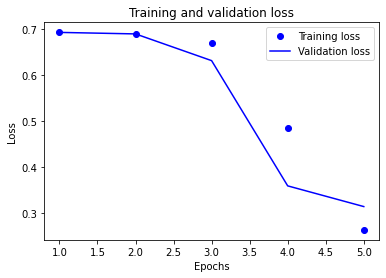

In [45]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

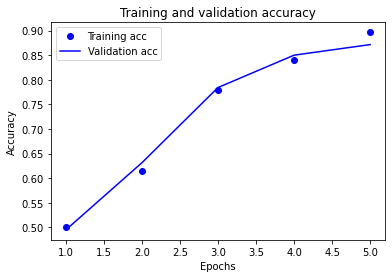

In [46]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Word embedding: 단어의 특성을 저차원 벡터값으로 표현   
[한국어 임베딩 읽을거리](https://ratsgo.github.io/natural%20language%20processing/2019/09/12/embedding/)

In [47]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [48]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [49]:
# embedding parameter 읽어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([-0.05039101, -0.05123914,  0.04391335, -0.01988915, -0.01148819,
       -0.03600633,  0.04791187, -0.00722545, -0.00669135, -0.02231818,
        0.03059721,  0.01437167, -0.04642817,  0.03620751,  0.02116725,
        0.00316889], dtype=float32)

In [50]:
# love과 유사한 단어
word_vectors.similar_by_word("love")

[('deeply', 0.8718148469924927),
 ('mary', 0.8691411018371582),
 ('lumet', 0.8624722361564636),
 ('aunts', 0.8620066046714783),
 ('gothic', 0.8575439453125),
 ('glow', 0.8498092889785767),
 ('sox', 0.843052864074707),
 ('sarandon', 0.8339055776596069),
 ('simplicity', 0.8327934145927429),
 ('pleasantly', 0.8322052955627441)]

In [51]:
# word2vec은 1억개의 단어로 구성된 googel news dataset 바탕으로 학습됨.
# 총 300만개의 단어로 300차원 벡터로 표현.
# https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [ ]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
#word2vec.similar_by_word("love")

In [52]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [55]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 580, 300)          3000000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 574, 16)           33616     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 114, 16)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 108, 16)           1808      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [56]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 15s 502ms/step - loss: 0.6965 - accuracy: 0.5155 - val_loss: 0.6893 - val_accuracy: 0.5458
Epoch 2/20
30/30 [==============================] - 6s 215ms/step - loss: 0.6843 - accuracy: 0.5675 - val_loss: 0.6809 - val_accuracy: 0.5776
Epoch 3/20
30/30 [==============================] - 7s 217ms/step - loss: 0.6608 - accuracy: 0.6292 - val_loss: 0.6501 - val_accuracy: 0.6253
Epoch 4/20
30/30 [==============================] - 6s 216ms/step - loss: 0.5741 - accuracy: 0.7279 - val_loss: 0.4977 - val_accuracy: 0.7894
Epoch 5/20
30/30 [==============================] - 6s 214ms/step - loss: 0.3805 - accuracy: 0.8517 - val_loss: 0.3386 - val_accuracy: 0.8583
Epoch 6/20
30/30 [==============================] - 6s 213ms/step - loss: 0.2602 - accuracy: 0.8973 - val_loss: 0.3054 - val_accuracy: 0.8713
Epoch 7/20
30/30 [==============================] - 6s 213ms/step - loss: 0.1937 - accuracy: 0.9281 - val_loss: 0.3165 - val_accuracy: 0.8697
Epoch

In [57]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 7s - loss: 0.5502 - accuracy: 0.8606
[0.5502118468284607, 0.8605999946594238]
